# Neutralizations for DMS data validation

In [61]:
import os
import warnings

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from plotnine import *

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import yaml
plt.rcParams['svg.fonttype'] = 'none'
print(f"Using `neutcurve` version {neutcurve.__version__}")

Using `neutcurve` version 2.1.0


In [62]:
warnings.simplefilter('ignore')

Read config file.

In [63]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [64]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

## Read in data

In [65]:
frac_infect = pd.read_csv(config['RBD_depletion_neuts'], index_col=0)

## Fit Hill curve to data using [`neutcurve`](https://jbloomlab.github.io/neutcurve/)

In [66]:
fits = neutcurve.CurveFits(frac_infect,  fixtop= True)

In [67]:
fitparams = (
    fits.fitParams(ics=[50, 90, 97,98, 99])
    .assign(NT50=lambda x: 1/x['ic50'])
    )

# couldn't get lambda / conditional statement to work with assign, so try it here:
fitparams['ic50_is_bound'] = fitparams['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)


In [68]:
fitparams.to_csv('results/depletion_neut_titers.csv', index=False)


In [69]:
color_list = ['#808080', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#000000', '#CC79A7']

## Plot neut curves

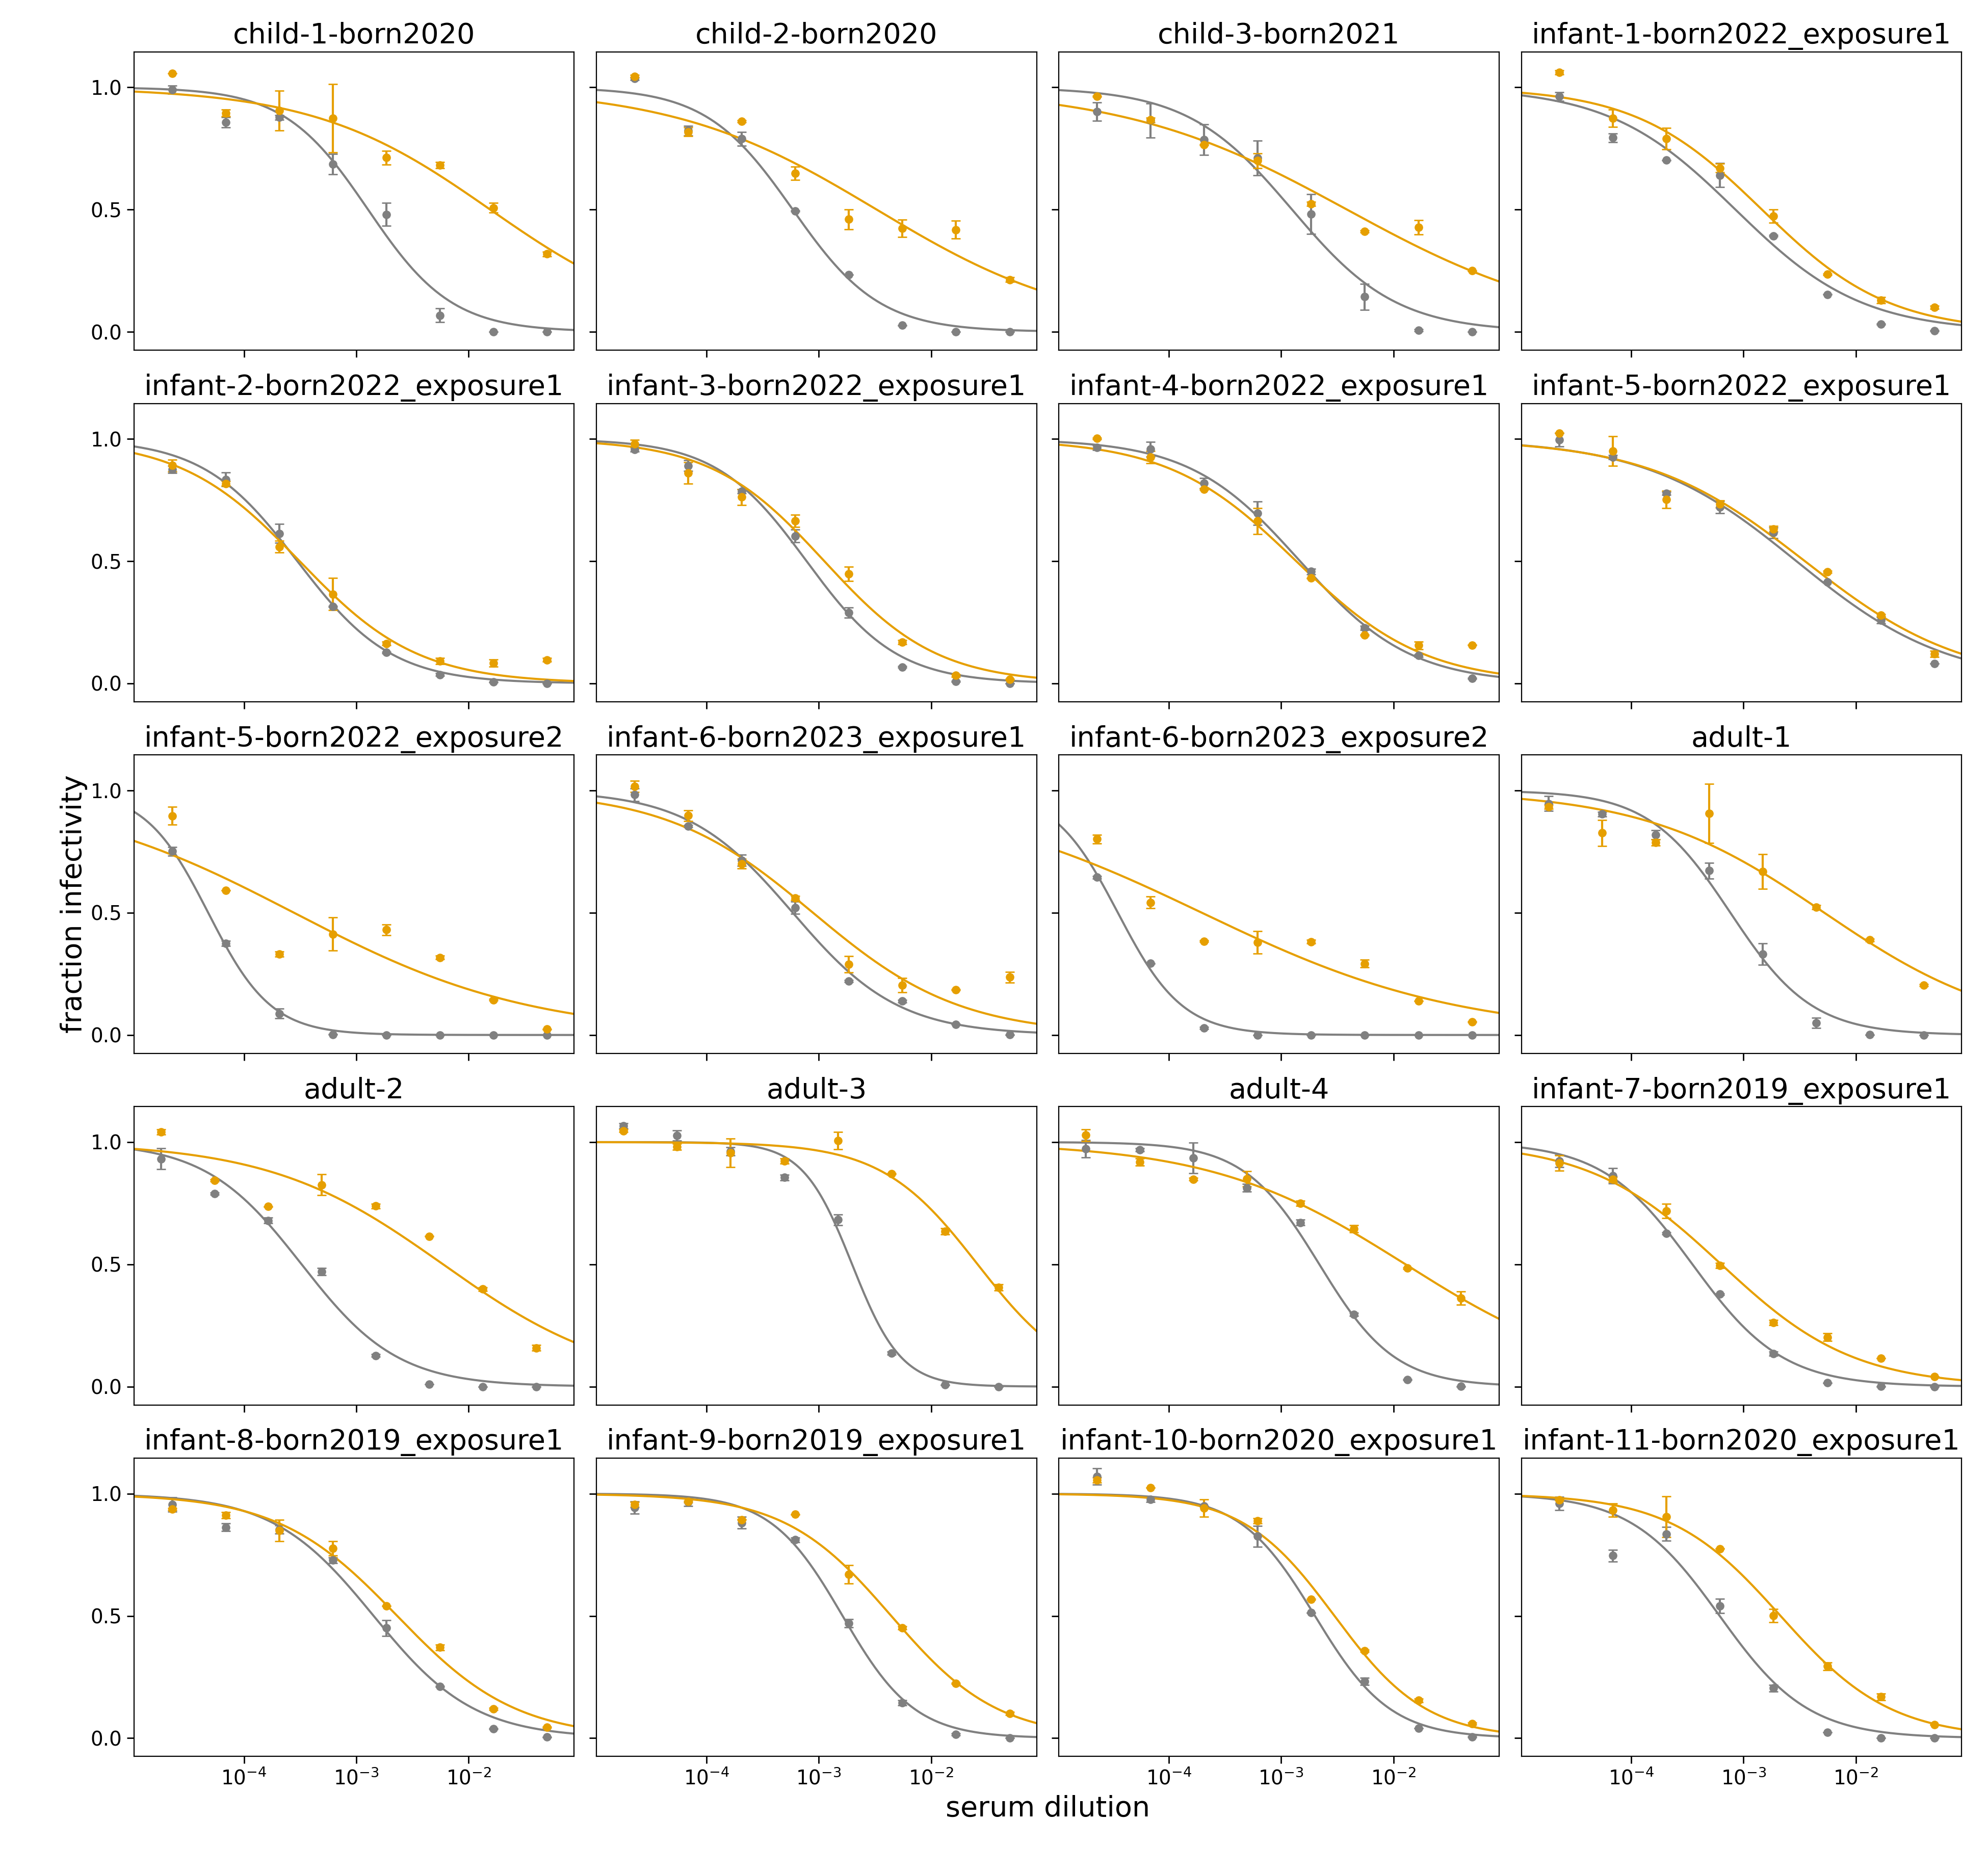

In [70]:
fig, axes = fits.plotSera(xlabel='serum dilution',
                          ncol=4,
                          widthscale=1.5,
                          heightscale=1.5,
                          titlesize=20, labelsize=20, ticksize=14,
                          legendfontsize=20, yticklocs=[0,0.5,1],
                          markersize=5, linewidth=1.5,
                          max_viruses_per_subplot = 9,
                          markers=['o','o','o','o','o','o','o', 'o', 'o'],
                          colors = color_list
                         )
plotfile_pdf = 'depletion_neuts.pdf'
plotfile_png = 'depletion_neuts.png'
fig.savefig(f'{resultsdir}/{plotfile_pdf}', bbox_inches='tight')
fig.savefig(f'{resultsdir}/{plotfile_png}', bbox_inches='tight')

In [71]:
# Mapping for group classification
group_mapping = {
    'child': [
        'child-1-born2020', 'child-2-born2020',
        'child-3-born2021', 'child-4-born2021'
    ],
    'XBB-infant-1': [
        'infant-1-born2022_exposure1', 'infant-2-born2022_exposure1',
        'infant-3-born2022_exposure1', 'infant-4-born2022_exposure1',
        'infant-5-born2022_exposure1', 'infant-6-born2023_exposure1'
    ],
    'XBB-infant-2': [
        'infant-5-born2022_exposure2', 'infant-6-born2023_exposure2'
    ],
    'adult': [
        'adult-1', 'adult-2', 'adult-3', 'adult-4'
    ],
    'Wu1-infant-1': [
        'infant-7-born2019_exposure1', 'infant-8-born2019_exposure1',
        'infant-9-born2019_exposure1', 'infant-10-born2020_exposure1',
        'infant-11-born2020_exposure1'
    ]
}

# Assign group based on serum value
def assign_group(serum_value):
    for group, keywords in group_mapping.items():
        if serum_value in keywords:
            return group
    return None  # If no match is found

# Apply the function
fitparams['group'] = fitparams['serum'].apply(assign_group)


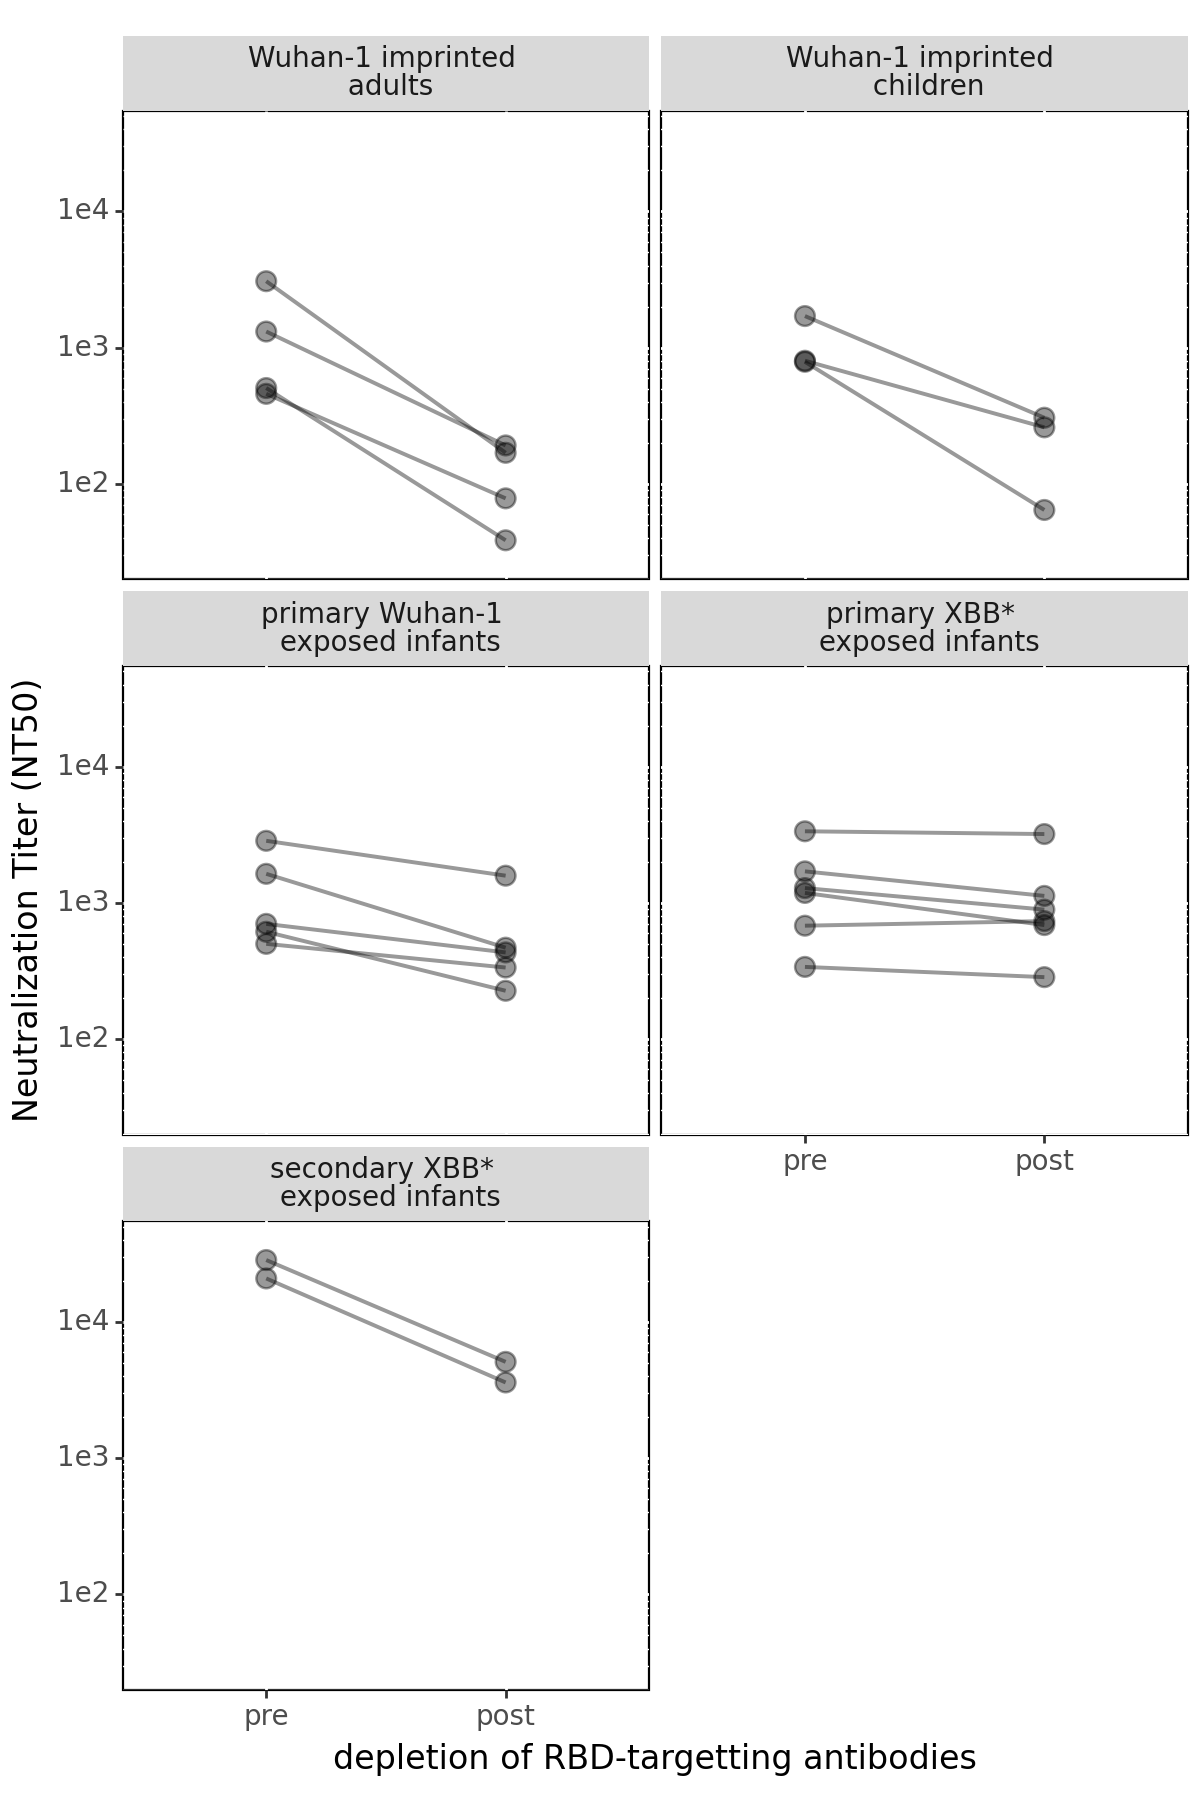

In [72]:
fitparams['group_label'] = fitparams['group'].map({
    'adult': 'Wuhan-1 imprinted \n adults',    
    'child': 'Wuhan-1 imprinted \n children',
    'XBB-infant-1': 'primary XBB* \n exposed infants',
    'XBB-infant-2': 'secondary XBB* \n exposed infants',
    'Wu1-infant-1': 'primary Wuhan-1 \n exposed infants'
})

fitparams['depletion'] = fitparams['virus'].map({
    'non-depleted': 'pre',    
    'depleted': 'post'
})

NT50_faceted = (ggplot(fitparams, aes(x='depletion', y='NT50', group='serum')) +
              geom_point(size=3.5, alpha = 0.4) +
              geom_line(size=.8, alpha = 0.4) +
              theme(
                   figure_size=(6,9),
                   axis_text=element_text(size=10),
                   axis_text_x=element_text(size=10),
                   legend_text=element_text(size=10),
                   axis_title_x=element_text(size=12),
                   axis_title_y=element_text(size=12),
                   strip_text=element_text(size=10),
                   panel_background=element_rect(fill='white'),
                   plot_background=element_rect(fill='white'),
                  panel_border=element_line(color='black', size=.8)
                  ) +
              scale_y_log10(expand=(0.03, .2)) +
              ylab('Neutralization Titer (NT50)') +
              xlab('depletion of RBD-targetting antibodies') +
              scale_color_manual(values=CBPALETTE[1:])+
              scale_x_discrete(limits=['pre', 'post']) +
              facet_wrap('~group_label', ncol=2)
               )


NT50_faceted.save("results/NT50s_depleted.svg", format="svg")
NT50_faceted.save("results/NT50s_depleted.png", format="png", dpi=300)
NT50_faceted.draw()

In [73]:
#add % RBD-targetting antibodies
df_pre = fitparams.loc[fitparams['virus'] == 'non-depleted']
df_post = fitparams.loc[fitparams['virus'] == 'depleted']
df_merge = pd.merge(df_pre, df_post, on="serum")
df_merge['percent_RBD'] = (df_merge['NT50_x']-df_merge['NT50_y'])/df_merge['NT50_x']*100
df_merge['percent_RBD'] = df_merge['percent_RBD'].astype(int)
fitparams = pd.merge(fitparams,df_merge[['serum','percent_RBD']],on='serum', how='left')
fitparams['percent_RBD_str'] = fitparams['percent_RBD'].astype(str) +'%'


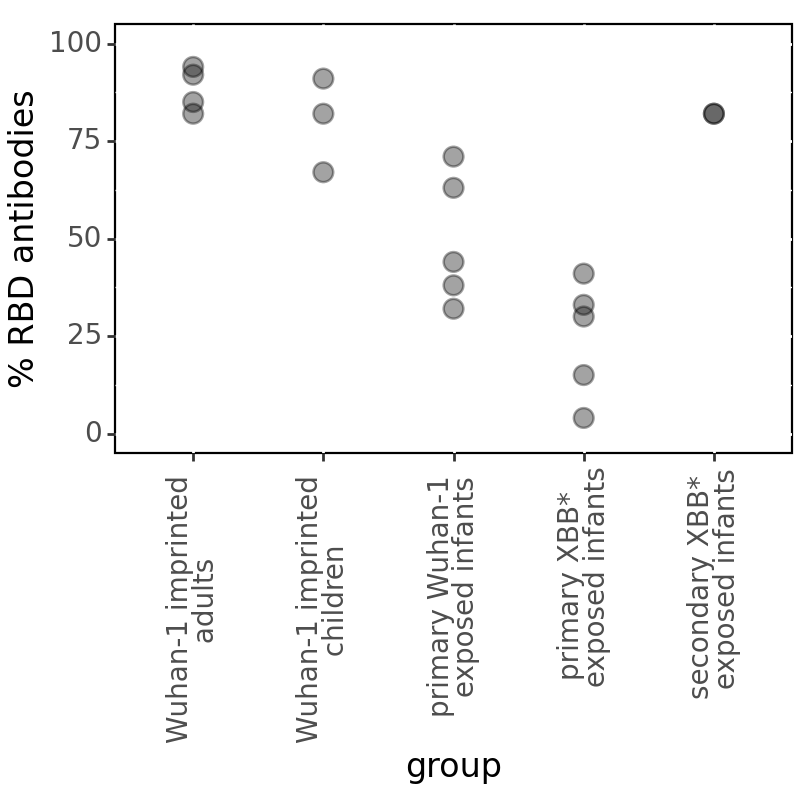

<Figure Size: (400 x 400)>

In [74]:
RBD_percent = (ggplot(fitparams, aes(x='group_label', y='percent_RBD')) +
              geom_point(size=3.5, alpha = 0.2) +
              theme(
                   figure_size=(4,4),
                   axis_text=element_text(size=10),
                   axis_text_x=element_text(size=10, angle = 90,),
                   legend_text=element_text(size=10),
                   axis_title_x=element_text(size=12),
                   axis_title_y=element_text(size=12),
                   strip_text=element_text(size=10),
                   panel_background=element_rect(fill='white'),
                   plot_background=element_rect(fill='white'),
                  panel_border=element_line(color='black', size=.8)
                  ) +
              ylim(0, 100) +
              ylab('% RBD antibodies') +
              xlab('group') +
              scale_color_manual(values=CBPALETTE[1:])
               )
RBD_percent.save("results/RBDpercent.svg", format="svg")
RBD_percent.save("results/RBDpercent.png", format="png", dpi=300)
RBD_percent

## Compare to Greaney 2021

In [75]:
Greaney_df = pd.read_csv(config['Greaney_2021'])
Greaney_df.head()

,sample,Participant ID,display_PID,Sex,Age,Severity,Days Post-Symptom Onset,serum,IC50_D614,NT50_D614,...,NT50_post,fold_change,percent_RBD,post_ic50_bound,perc_RBD_str,mapped,RBD IgA,RBD IgG,RBD IgM,Spike IgG
0,1823354D,24C,subject C,Female,76.0,Symptomatic Non-Hospitalized,104.0,subject C (day 104),0.001125,889.275933,...,20.000000,69.152358,98,True,>98%,True,1.788944,9.724312,2.646436,12.599270
1,2AD43D3B,24C,subject C,Female,76.0,Symptomatic Non-Hospitalized,32.0,subject C (day 32),0.000174,5761.315215,...,27.756167,125.366727,99,False,99%,True,1.880786,11.449408,5.090334,13.740618
2,96D33AAD,23,subject A,Male,56.0,Symptomatic Hospitalized,120.0,subject A (day 120),0.003629,275.589130,...,20.000000,43.058197,97,True,>97%,True,1.039513,11.567948,2.531512,13.715131
3,EDD7CFC8,23,subject A,Male,56.0,Symptomatic Hospitalized,21.0,subject A (day 21),0.000088,11346.781023,...,845.146407,8.142050,87,False,87%,True,7.238536,14.218570,5.931399,14.888339
4,331416C9,23,subject A,Male,56.0,Symptomatic Hospitalized,45.0,subject A (day 45),0.000233,4292.302775,...,462.175561,5.954031,83,False,83%,True,2.572616,12.718140,5.224112,14.704596


In [77]:
# Create the 'group' column based on the conditions
Greaney_df['group'] = Greaney_df['Days Post-Symptom Onset'].apply(
    lambda x: 'adults (15-40)' if x <= 40 else ('adults (41-80)' if x <= 80 else 'adults (>80)')
)


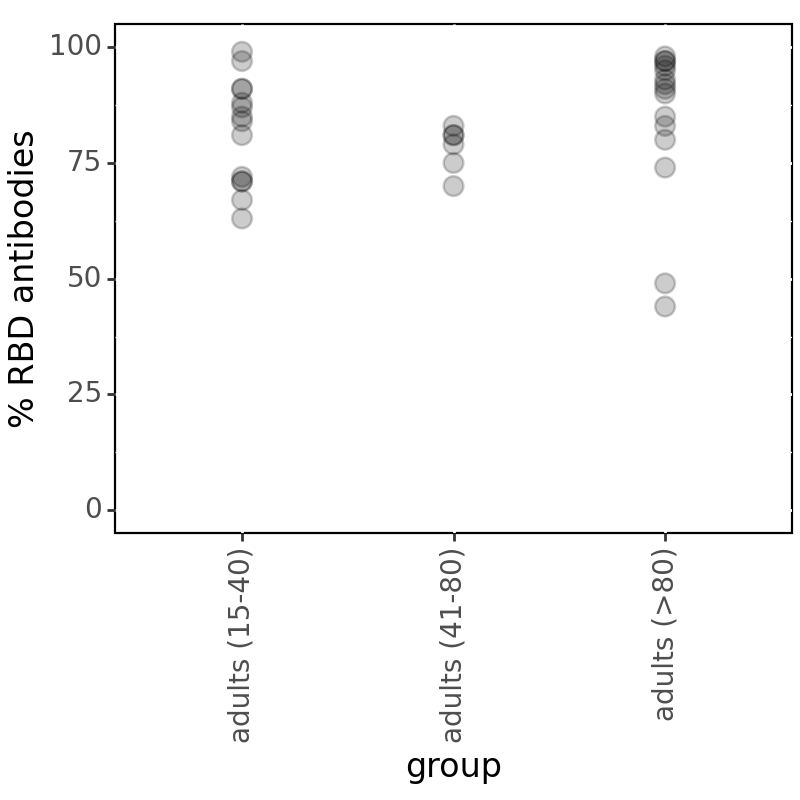

<Figure Size: (400 x 400)>

In [78]:
RBD_percent_greaney_30d = (ggplot(Greaney_df, aes(x='group', y='percent_RBD')) +
              geom_point(size=3.5, alpha = 0.2) +
              theme(
                   figure_size=(4,4),
                   axis_text=element_text(size=10),
                   axis_text_x=element_text(size=10, angle = 90),
                   legend_text=element_text(size=10),
                   axis_title_x=element_text(size=12),
                   axis_title_y=element_text(size=12),
                   strip_text=element_text(size=10),
                   panel_background=element_rect(fill='white'),
                   plot_background=element_rect(fill='white'),
                  panel_border=element_line(color='black', size=.8)
                  ) +
              ylim(0, 100) +
              ylab('% RBD antibodies') +
              xlab('group') +
              scale_color_manual(values=CBPALETTE[1:])
               )
RBD_percent_greaney_30d.save("results/RBD_percent_greaney.svg", format="svg")
RBD_percent_greaney_30d.save("results/RBD_percent_greaney.png", format="png", dpi=300)
RBD_percent_greaney_30d

In [79]:
# Melting the DataFrame
melted_df = pd.melt(
    Greaney_df,
    id_vars=['sample'],
    value_vars=['NT50_D614', 'NT50_post'],
    var_name='depletion',
    value_name='NT50'
)

,sample,depletion,NT50
0,1823354D,NT50_D614,889.275933
1,2AD43D3B,NT50_D614,5761.315215
2,96D33AAD,NT50_D614,275.589130
3,EDD7CFC8,NT50_D614,11346.781023
4,331416C9,NT50_D614,4292.302775
...,...,...,...
65,65C28B8D,NT50_post,303.438688
66,9EC82418,NT50_post,368.849022
67,79BD0F7A,NT50_post,165.836664
68,50BDD720,NT50_post,20.000000


In [80]:
melted_df['depletion'] = melted_df['depletion'].replace({
    'NT50_D614': 'pre',
    'NT50_post': 'post'
})

,sample,depletion,NT50
0,1823354D,pre,889.275933
1,2AD43D3B,pre,5761.315215
2,96D33AAD,pre,275.589130
3,EDD7CFC8,pre,11346.781023
4,331416C9,pre,4292.302775
...,...,...,...
65,65C28B8D,post,303.438688
66,9EC82418,post,368.849022
67,79BD0F7A,post,165.836664
68,50BDD720,post,20.000000


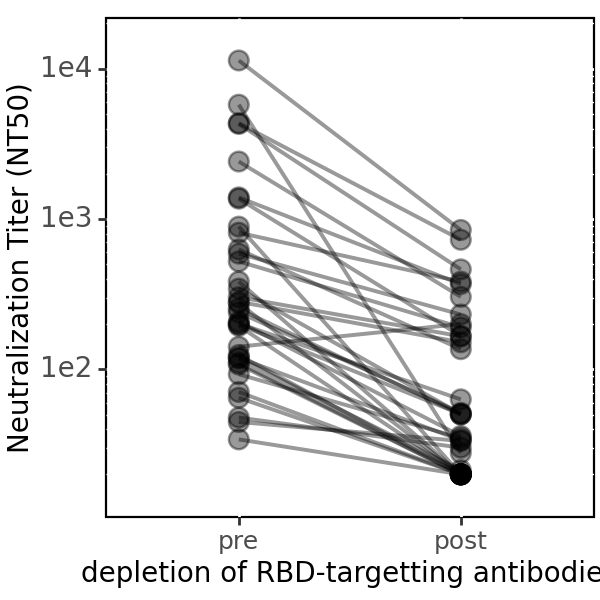

In [81]:
NT50_AG_adult = (ggplot(melted_df, aes(x='depletion', y='NT50', group='sample')) +
              geom_point(size=3.5, alpha = 0.4) +
              geom_line(size=.8, alpha = 0.4) +
              theme(
                   figure_size=(3,3),
                   axis_text=element_text(size=10),
                   axis_text_x=element_text(size=9),
                   legend_text=element_text(size=10),
                   axis_title_x=element_text(size=10),
                   axis_title_y=element_text(size=10),
                   strip_text=element_text(size=10),
                   panel_background=element_rect(fill='white'),
                   plot_background=element_rect(fill='white'),
                  panel_border=element_line(color='black', size=.8)
                  ) +
              scale_y_log10(expand=(0.03, .2)) +
              ylab('Neutralization Titer (NT50)') +
              xlab('depletion of RBD-targetting antibodies') +
              scale_color_manual(values=CBPALETTE[1:])+
              scale_x_discrete(limits=['pre', 'post'])
               )


NT50_AG_adult.save("results/NT50_AG_adult_depletion.svg", format="svg")
NT50_AG_adult.save("results/NT50_AG_adult_depletion.png", format="png", dpi=300)
NT50_AG_adult.draw()

In [82]:
melted_df['group_label'] = 'primary Wuhan-1 \n exposed adults'

In [83]:
infants = fitparams.loc[
    fitparams['group_label'].isin([
        'primary XBB* \n exposed infants',
        'primary Wuhan-1 \n exposed infants'
    ])
]
infants['sample'] = infants['serum']

In [84]:
df = pd.concat([infants, melted_df],ignore_index = True)

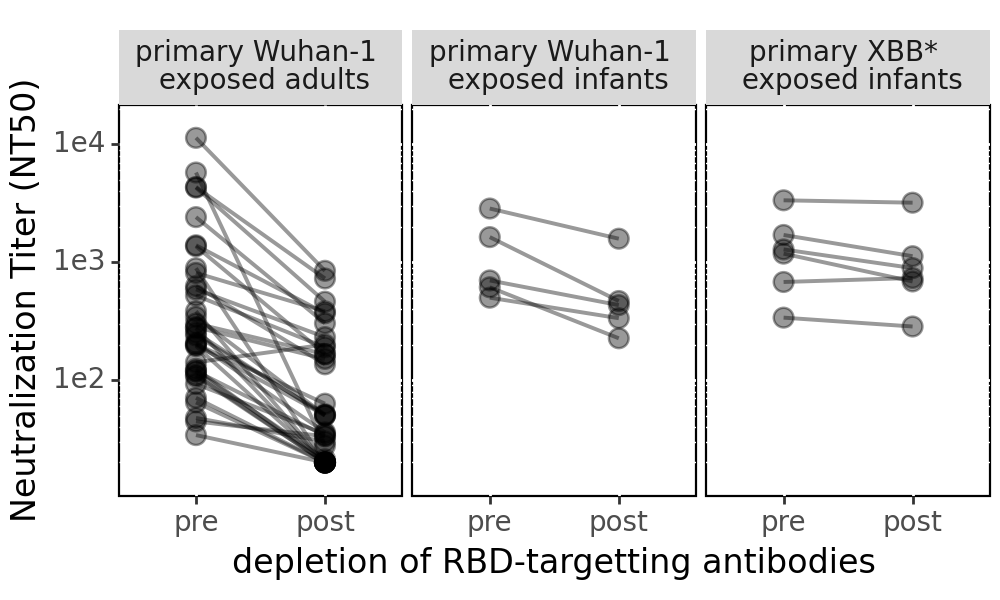

In [85]:
AG_BD_compare = (ggplot(df, aes(x='depletion', y='NT50', group='sample')) +
              geom_point(size=3.5, alpha = 0.4) +
              geom_line(size=.8, alpha = 0.4) +
              theme(
                   figure_size=(5,3),
                   axis_text=element_text(size=10),
                   axis_text_x=element_text(size=10),
                   legend_text=element_text(size=10),
                   axis_title_x=element_text(size=12),
                   axis_title_y=element_text(size=12),
                   strip_text=element_text(size=10),
                   panel_background=element_rect(fill='white'),
                   plot_background=element_rect(fill='white'),
                  panel_border=element_line(color='black', size=.8)
                  ) +
              scale_y_log10(expand=(0.03, .2)) +
              ylab('Neutralization Titer (NT50)') +
              xlab('depletion of RBD-targetting antibodies') +
              scale_color_manual(values=CBPALETTE[1:])+
              scale_x_discrete(limits=['pre', 'post']) +
              facet_wrap('~group_label', ncol=4)
               )


AG_BD_compare.save("results/NT50s_adult_wu1_infant_XBB.svg", format="svg")
AG_BD_compare.save("results/NT50s_adult_wu1_infant_XBB.png", format="png", dpi=300)
AG_BD_compare.draw()